In [40]:
import pandas as pd
file = 'ENDCBSFILE.csv'
df = pd.read_csv(file, low_memory=False)

In [41]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

def convert_to_num(df):
    labelencoder = LabelEncoder()
    
    # Encode 'gm_naam' column
    df['gm_naam'] = labelencoder.fit_transform(df['gm_naam'])
    
    # Encode 'gwb_code' column
    df['gwb_code'] = labelencoder.fit_transform(df['gwb_code'])
    
    return df


def normalize_data(df):

    # Select only numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Alternative: Standardization (mean=0, std=1)
    std_scaler = StandardScaler()
    df_standardized = std_scaler.fit_transform(df[num_cols])

    # Convert NumPy array back to DataFrame
    df_standardized = pd.DataFrame(df_standardized, columns=num_cols, index=df.index)


    return df_standardized



def df_for_training(df):
    # Encode categorical columns
    df = convert_to_num(df)
    
    df = df.drop(columns=['regio', 'ind_wbi'])

    #df = normalize_data(df)
    
    return df

# Apply the transformation
df_train = df.copy()
df_train = df_for_training(df_train)

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51854 entries, 0 to 51853
Data columns (total 69 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gm_naam   51854 non-null  int64  
 1   gwb_code  51854 non-null  int64  
 2   year      51854 non-null  int64  
 3   woz       51854 non-null  float64
 4   a_inw     51854 non-null  float64
 5   a_man     51854 non-null  float64
 6   a_vrouw   51854 non-null  float64
 7   a_geb     51854 non-null  float64
 8   p_geb     51854 non-null  float64
 9   a_ste     51854 non-null  float64
 10  p_ste     51854 non-null  float64
 11  a_hh      51854 non-null  float64
 12  g_hhgro   51854 non-null  float64
 13  bev_dich  51854 non-null  float64
 14  a_woning  51854 non-null  float64
 15  p_1gezw   51854 non-null  float64
 16  p_mgezw   51854 non-null  float64
 17  p_leegsw  51854 non-null  float64
 18  p_koopw   51854 non-null  float64
 19  p_huurw   51854 non-null  float64
 20  p_wcorpw  51854 non-null  fl

## Step 1: Feature importance

#### GA

Selected Features: ['gm_naam', 'gwb_code', 'year', 'bev_dich', 'a_woning', 'p_1gezw', 'p_koopw', 'g_ele', 'g_ele_hu', 'g_ele_ko', 'g_gas_ko', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_hh_hi', 'p_hh_lkk', 'pst_mvp', 'ste_oad']


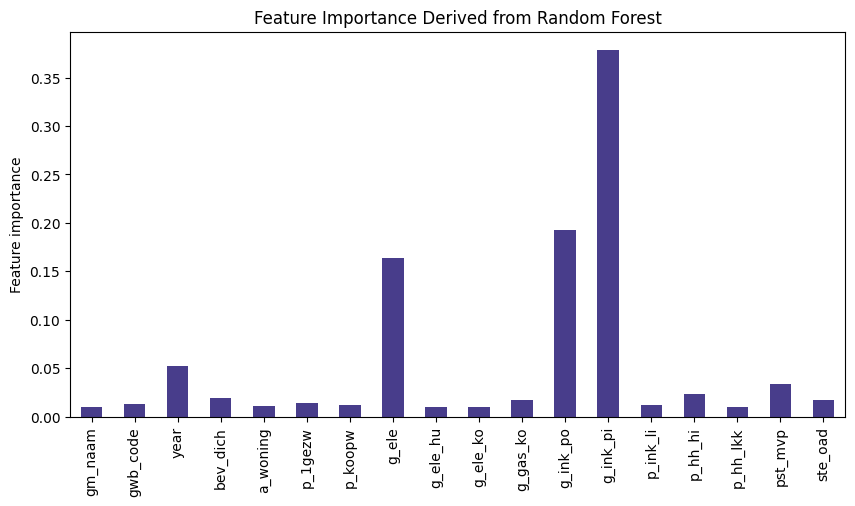

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

def rfe_feature_selection(df):

    # Split the data
    X_train, X_test, y_train, y_test = split_data(df_train, 2024)
    
     # Define the model (fewer trees for faster selection)
    regressor = RandomForestRegressor(n_jobs=-1, n_estimators=20, random_state=42)

    # Use RFECV for automatic feature selection with cross-validation
    rfe = RFECV(estimator=regressor, step=5, min_features_to_select=10, cv=3, n_jobs=-1)

    # Fit RFE to select features
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    print("Selected Features:", list(selected_features))

    # Train the model again on selected features
    regressor.fit(X_train[selected_features], y_train)
    predictions = regressor.predict(X_test[selected_features])

    feature_importances = pd.Series(regressor.feature_importances_, index=selected_features)


    return feature_importances, selected_features, regressor

# Run the function
feature_importances, selected_features, regressor = rfe_feature_selection(df_train)

# Feature importance plot
plt.figure(figsize=(10, 5))
feature_importances.plot.bar(color="darkslateblue")  # Set bar color
plt.ylabel("Feature importance")
plt.title("Feature Importance Derived from Random Forest")
plt.show()


In [26]:
selected_features = ['gwb_code', 'year', 'woz', , 'bev_dich', 'a_woning', 'g_ele', 
                     'g_gas', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_ink_hi', 'p_hh_hi', 
                     'p_hh_lkk', 'pst_mvp', 'ste_oad']



print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51854 entries, 0 to 51853
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gwb_code  51854 non-null  int64  
 1   year      51854 non-null  int64  
 2   woz       51854 non-null  float64
 3   g_hhgro   51854 non-null  float64
 4   bev_dich  51854 non-null  float64
 5   a_woning  51854 non-null  float64
 6   g_ele     51854 non-null  float64
 7   g_gas     51854 non-null  float64
 8   g_ink_po  51854 non-null  float64
 9   g_ink_pi  51854 non-null  float64
 10  p_ink_li  51854 non-null  float64
 11  p_ink_hi  51854 non-null  float64
 12  p_hh_hi   51854 non-null  float64
 13  p_hh_lkk  51854 non-null  float64
 14  pst_mvp   51854 non-null  float64
 15  ste_oad   51854 non-null  float64
dtypes: float64(14), int64(2)
memory usage: 6.3 MB
None


## Step 2: Split data

In [5]:
def split_data(df, test_year):
    train_df = df[df['year'] < test_year]
    test_df = df[df['year'] == test_year]  # Use 2024 as test year
    
    # Define features and target
    X_train = train_df.drop(columns=['woz'])
    y_train = train_df['woz']
    X_test = test_df.drop(columns=['woz'])
    y_test = test_df['woz']

    return X_train, X_test, y_train, y_test

X_train_S, X_test_S, y_train_S, y_test_S = split_data(df_selected, 2024)
X_train, X_test, y_train, y_test = split_data(df_train, 2024)

In [40]:
def split_data_iterate_testyear(df, first_test_year):



    unique_years = sorted(df['year'].unique())
    
    # Example: Starting with a minimum training period (say, 2015-2018), then test on 2019, then train on 2015-2019, test on 2020, etc.
    for test_year in range(first_test_year, (int(unique_years[-1]) + 1)):
        print(f"processing for test year: {test_year}")
        
        train_df = df[df['year'] < test_year]
        test_df = df[df['year'] == test_year]  
        
        # Define features and target
        X_train = train_df.drop(columns=['woz'])
        y_train = train_df['woz']
        X_test = test_df.drop(columns=['woz'])
        y_test = test_df['woz']


        y_pred = XGB(X_train, X_test, y_train)
        

        result_XGB, mse_XGB, r2_XGB = evaluate_model(y_test, y_pred)


    
    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test = split_data_iterate_testyear(df_train, 2018)

processing for test year: 2018
Mean Squared Error (MSE): 1776.5549175278181
R-squared (R2): 0.8841866176938948

Predictions vs Actual:
      Actual   Predicted
0      339.0  294.149628
1      623.0  514.112793
2      668.0  573.449463
3      551.0  488.652008
4      299.0  298.676880
...      ...         ...
4944   225.0  214.987930
4945   221.0  212.696075
4946   551.0  586.156982
4947   268.0  255.595001
4948   439.0  450.495270

[4949 rows x 2 columns]
processing for test year: 2019
Mean Squared Error (MSE): 2244.911367851896
R-squared (R2): 0.8690555666414179

Predictions vs Actual:
      Actual   Predicted
0      366.0  313.268555
1      581.0  555.413147
2      582.0  596.376221
3      601.0  469.563568
4      336.0  313.121796
...      ...         ...
4944   244.0  234.354904
4945   238.0  224.393036
4946   753.0  470.516357
4947   281.0  242.981369
4948   455.0  461.790039

[4949 rows x 2 columns]
processing for test year: 2020
Mean Squared Error (MSE): 2508.1492934833504
R-squ

## Step 2: Train model


In [11]:
def evaluate_model(y_test, y_pred):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    
    # Display predictions alongside actual values
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
    print("\nPredictions vs Actual:")
    print(results)

    return results, mse, r2

### XGB
https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/


In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200, 300, 500],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Tree depth
}

# Initialize the model
xgb = XGBRegressor(random_state=42)

# Perform GridSearchCV
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
#                            scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='r2', cv=5, verbose=1, n_jobs=-1)


train_df =df_train.copy()
    # Define features and target
X_f = train_df.drop(columns=['woz'])
y_f = train_df['woz']


# Fit the model
grid_search.fit(X_f, y_f)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best score: 0.8658759256650146


In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


def XGB(X_train, X_test, y_train):

    # Train an XGBoost Regressor
    model = XGBRegressor(n_estimators=700, learning_rate=0.1, max_depth=5, random_state=42, early_stopping_rounds=50)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train)])
    
    # Predict on the test set
    y_pred = model.predict(X_test)

    return y_pred

# Get values
y_pred = XGB(X_train, X_test, y_train)

[0]	validation_0-rmse:132.16164
[1]	validation_0-rmse:122.58438
[2]	validation_0-rmse:114.20460
[3]	validation_0-rmse:106.67776
[4]	validation_0-rmse:99.96824
[5]	validation_0-rmse:94.04951
[6]	validation_0-rmse:88.82247
[7]	validation_0-rmse:84.17771
[8]	validation_0-rmse:80.00033
[9]	validation_0-rmse:76.30861
[10]	validation_0-rmse:73.07034
[11]	validation_0-rmse:70.16608
[12]	validation_0-rmse:67.56153
[13]	validation_0-rmse:65.24469
[14]	validation_0-rmse:63.25885
[15]	validation_0-rmse:61.38474
[16]	validation_0-rmse:59.72523
[17]	validation_0-rmse:58.23641
[18]	validation_0-rmse:56.94458
[19]	validation_0-rmse:55.77525
[20]	validation_0-rmse:54.62115
[21]	validation_0-rmse:53.56968
[22]	validation_0-rmse:52.64489
[23]	validation_0-rmse:51.82445
[24]	validation_0-rmse:50.93598
[25]	validation_0-rmse:50.23163
[26]	validation_0-rmse:49.57629
[27]	validation_0-rmse:48.96334
[28]	validation_0-rmse:48.35051
[29]	validation_0-rmse:47.76261
[30]	validation_0-rmse:47.13104
[31]	validatio

In [13]:
print(y_test)

Mean Squared Error (MSE): 6830.2992569491025
R-squared (R2): 0.757316310935429

Series([], Name: woz, dtype: float64)


In [26]:
result_XGB, mse_XGB, r2_XGB = evaluate_model(y_test, y_pred)

Mean Squared Error (MSE): 2017.894932063204
R-squared (R2): 0.9298890625744868

Predictions vs Actual:
      Actual   Predicted
0      520.0  484.843933
1      756.0  689.358887
2      744.0  679.162842
3      790.0  710.453186
4      495.0  519.513916
...      ...         ...
4709   366.0  385.773041
4710   358.0  364.840820
4711  1080.0  684.423828
4712   417.0  383.937195
4713   599.0  634.868164

[4714 rows x 2 columns]


In [30]:
# Get values
y_pred_S = XGB(X_train_S, X_test_S, y_train_S)
result_XGB_S, mse_XGB_S, r2_XGB_S = evaluate_model(y_test_S, y_pred_S)

Mean Squared Error (MSE): 3814.5032581164833
R-squared (R2): 0.8674666381337419

Predictions vs Actual:
      Actual   Predicted
0      520.0  477.216888
1      756.0  671.333435
2      744.0  679.941956
3      790.0  700.419067
4      495.0  510.089172
...      ...         ...
4709   366.0  383.105225
4710   358.0  364.919403
4711  1080.0  531.649597
4712   417.0  396.090057
4713   599.0  654.042053

[4714 rows x 2 columns]


### Gradient Boosting 

#### Without parallel computation

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

def gboost_no_parallel(X_train, X_test, y_train):
    
    gbr_no_parallel = GradientBoostingRegressor(
        n_estimators=100,  # Number of trees
        learning_rate=0.1,  # Step size
        max_depth=3,  # Max depth of each tree
        random_state=42  # For reproducibility
    )
    
    # Fit the model
    gbr_no_parallel.fit(X_train, y_train)

    # Make predictions
    y_pred_no_parallel = gbr_no_parallel.predict(X_test)
    return y_pred_no_parallel
    
# Get values
y_pred_no_parallel = gboost_no_parallel(X_train, X_test, y_train)


In [9]:
result_no_parallel, mse_np, r2_np = evaluate_model(y_test, y_pred_no_parallel)

Mean Squared Error (MSE): 4835.667994702326
R-squared (R2): 0.8319866853322805

Predictions vs Actual:
      Actual   Predicted
0      520.0  451.727438
1      756.0  646.381051
2      744.0  608.663785
3      790.0  693.866268
4      495.0  590.485354
...      ...         ...
4709   366.0  373.901300
4710   358.0  344.447550
4711  1080.0  498.880328
4712   417.0  397.762240
4713   599.0  619.484374

[4714 rows x 2 columns]


#### With parallel computation

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor

def gboost_parallel(X_train, X_test, y_train):
    
    # Gradient Boosting Model WITH parallel computation
    gbr_with_parallel = HistGradientBoostingRegressor(
        max_iter=100,  # Number of boosting iterations
        learning_rate=0.1,  # Step size
        max_depth=3,  # Max depth of each tree
        random_state=42,  # For reproducibility
    )
    
    # Fit the model
    gbr_with_parallel.fit(X_train, y_train)
    
    # Make predictions
    y_pred_with_parallel = gbr_with_parallel.predict(X_test)

    return y_pred_with_parallel
    
# Get values
y_pred_with_parallel = gboost_parallel(X_train, X_test, y_train)

In [11]:
result_with_parallel, mse_wp, r2_wp = evaluate_model(y_test, y_pred_with_parallel)

Mean Squared Error (MSE): 4843.307263148243
R-squared (R2): 0.8317212620619813

Predictions vs Actual:
      Actual   Predicted
0      520.0  452.882868
1      756.0  644.971424
2      744.0  623.488535
3      790.0  706.937877
4      495.0  567.169989
...      ...         ...
4709   366.0  383.154410
4710   358.0  350.186020
4711  1080.0  529.544610
4712   417.0  389.852373
4713   599.0  641.243778

[4714 rows x 2 columns]


### Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor
#Best parameters: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}

def random_forest(X_train, X_test, y_train):
    
    rf = RandomForestRegressor(
        n_estimators=400,  # Number of trees in the forest
        max_depth=10,  # Maximum depth of each tree (can be tuned)
        random_state=42,  # For reproducibility
        n_jobs=-1  # Use all available CPU cores for parallel computation
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    return y_pred
    
# Get values
y_pred_rf = random_forest(X_train, X_test, y_train)

In [39]:
result_rf, mse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

Mean Squared Error (MSE): 4312.231857415434
R-squared (R2): 0.8501732607007269

Predictions vs Actual:
      Actual   Predicted
0      520.0  467.625440
1      756.0  641.400867
2      744.0  660.861321
3      790.0  701.955269
4      495.0  586.094370
...      ...         ...
4709   366.0  401.444051
4710   358.0  379.709910
4711  1080.0  835.174918
4712   417.0  414.401375
4713   599.0  542.388914

[4714 rows x 2 columns]


## Models evaluation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_m_r(mse_scores, r2_scores):
    # Example values for different models (replace these with your actual values)
    models = ['XGBoost', 'XGBoost - REF', 'Random Forest', 'Random Forest - REF']

    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Bar plot for R² scores
    bar_width = 0.35
    index = np.arange(len(models))
    
    bar1 = ax1.bar(index, r2_scores, bar_width, label='R²', color='b', alpha=0.6)
    
    # Create a second y-axis for MSE scores
    ax2 = ax1.twinx()
    bar2 = ax2.bar(index + bar_width, mse_scores, bar_width, label='MSE', color='r', alpha=0.6)
    
    # Set labels
    ax1.set_xlabel('Model')
    ax1.set_ylabel('R²', color='b')
    ax2.set_ylabel('MSE', color='r')
    
    # Add some labels and titles
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(models)
    ax1.set_title('Comparison of R² and MSE for Different Models')
    
    # Show legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_m_r([mse_XGB, mse_np, mse_wp, mse_rf], [r2_XGB, r2_np, r2_wp, r2_rf])

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import pandas as pd

def feature_selection(X_train, y_train, threshold="median"):

    rf = RandomForestRegressor(random_state=42, n_estimators=100)
    rf.fit(X_train, y_train)
    
    importances = rf.feature_importances_
    feature_names = X_train.columns
    
    selector = SelectFromModel(rf, threshold=threshold, prefit=True)
    selected_features = feature_names[selector.get_support()]
    
    X_train_selected = selector.transform(X_train)
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
    
    print(f"Selected Features ({len(selected_features)}): {selected_features.tolist()}")
    
    return selected_features.tolist(), X_train_selected

# Example usage
selected_features, X_train_selected = feature_selection(X_train, y_train)



Selected Features (34): ['gm_naam', 'gwb_code', 'year', 'g_hhgro', 'bev_dich', 'p_1gezw', 'p_mgezw', 'p_leegsw', 'p_koopw', 'p_huurw', 'p_ov_hw', 'g_ele', 'g_ele_vw', 'g_ele_hu', 'g_ele_ko', 'g_gas', 'g_gas_vw', 'g_gas_hu', 'g_gas_ko', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_ink_hi', 'p_hh_li', 'p_hh_hi', 'p_hh_lkk', 'g_pau_hh', 'g_pau_km', 'g_afs_gs', 'g_3km_sc', 'a_opp_ha', 'a_lan_ha', 'pst_mvp', 'ste_oad']


/home/wouter/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [41]:
df_selec_col = df_train.copy()

selected_columns = [
    'gm_naam', 'gwb_code', 'year', 'woz', 'g_hhgro', 'bev_dich', 'a_woning', 'p_1gezw', 
    'p_mgezw', 'p_leegsw', 'p_koopw', 'g_ele', 'g_ele_vw', 'g_ele_hu', 'g_ele_ko', 
    'g_gas', 'g_gas_vw', 'g_gas_hu', 'g_gas_ko', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 
    'p_ink_hi', 'p_hh_li', 'p_hh_hi', 'p_hh_lkk', 'a_bst_nb', 'g_pau_hh', 'g_pau_km', 
    'g_3km_sc', 'a_opp_ha', 'a_lan_ha', 'a_wat_ha', 'pst_mvp', 'ste_oad'
]

# Select the specified columns from the DataFrame
df_selec_col = df_selec_col[selected_columns]
print(df_selec_col.info())

X_train_F, X_test_F, y_train_F, y_test_F = split_data(df_selec_col, 2024)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51854 entries, 0 to 51853
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gm_naam   51854 non-null  int64  
 1   gwb_code  51854 non-null  int64  
 2   year      51854 non-null  int64  
 3   woz       51854 non-null  float64
 4   g_hhgro   51854 non-null  float64
 5   bev_dich  51854 non-null  float64
 6   a_woning  51854 non-null  float64
 7   p_1gezw   51854 non-null  float64
 8   p_mgezw   51854 non-null  float64
 9   p_leegsw  51854 non-null  float64
 10  p_koopw   51854 non-null  float64
 11  g_ele     51854 non-null  float64
 12  g_ele_vw  51854 non-null  float64
 13  g_ele_hu  51854 non-null  float64
 14  g_ele_ko  51854 non-null  float64
 15  g_gas     51854 non-null  float64
 16  g_gas_vw  51854 non-null  float64
 17  g_gas_hu  51854 non-null  float64
 18  g_gas_ko  51854 non-null  float64
 19  g_ink_po  51854 non-null  float64
 20  g_ink_pi  51854 non-null  fl

In [42]:
y_pred_F = XGB(X_train_F, X_test_F, y_train_F)

result_XGB_F, mse_XGB_F, r2_XGB_F = evaluate_model(y_test_F, y_pred_F)

Mean Squared Error (MSE): 3412.209414013089
R-squared (R2): 0.8814441738728122

Predictions vs Actual:
      Actual   Predicted
0      520.0  453.854889
1      756.0  664.174255
2      744.0  668.344177
3      790.0  691.795471
4      495.0  561.047485
...      ...         ...
4709   366.0  387.689728
4710   358.0  369.239716
4711  1080.0  606.989197
4712   417.0  391.155029
4713   599.0  619.956909

[4714 rows x 2 columns]


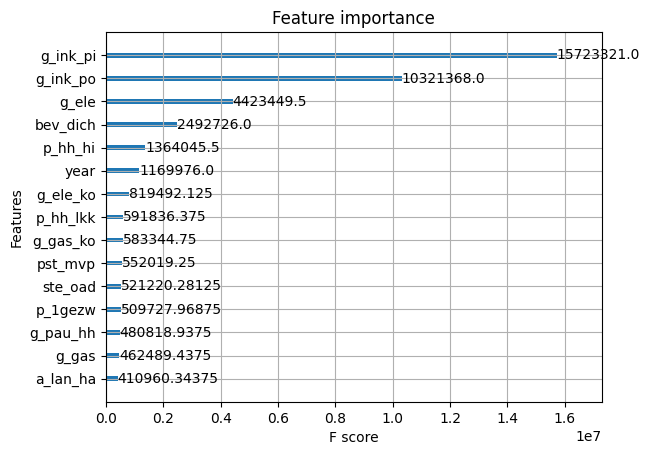

In [43]:
import xgboost as xgb
import matplotlib.pyplot as plt

def plot_feature_importance(model, importance_type='weight'):
    booster = model.get_booster()
    
    # Plot feature importance
    xgb.plot_importance(booster, importance_type=importance_type, max_num_features=15)
    plt.show()

# Train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_F, y_train_F)

# Predict on the test set
y_pred_F = model.predict(X_test_F)

# Plot feature importance
plot_feature_importance(model, importance_type='gain')  # You can also try 'gain' or 'cover'


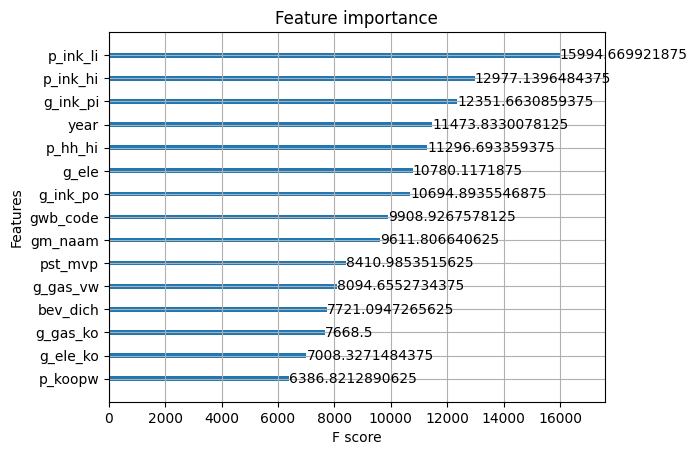

In [44]:
plot_feature_importance(model, importance_type='cover')  # You can also try 'gain' or 'cover'


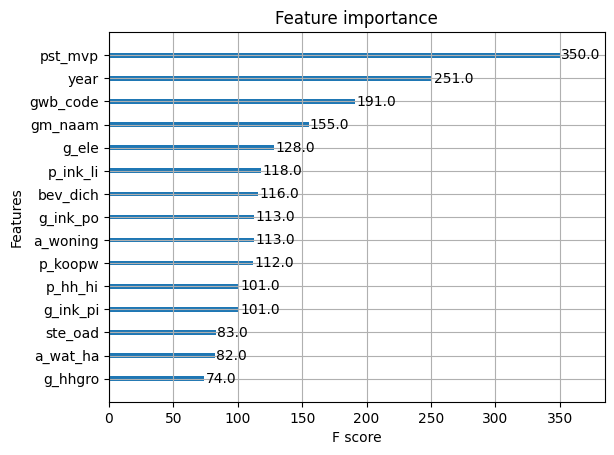

In [45]:
plot_feature_importance(model, importance_type='weight')  # You can also try 'gain' or 'cover'


In [ ]:
z

### Predict woz values for neighborhood for 2025 and 2026